In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#load Yearly HM
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import sys
sys.path.insert(0, '../Common/')

import matplotlib.pyplot as plt
import numpy as np

from AISDataManager import AISDataManager
import Constants as c
import pandas as pd
from GridClass import GridClass

import os
import matplotlib.animation as animation
from IPython.display import HTML

#config parser
import configparser

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing

#make object of AIS data manager
aISDM = AISDataManager()

# lonMin = (float)(config['REGEION']['LON_MIN'])
# lonMax = (float)(config['REGEION']['LON_MAX'])

# latMin = (float)(config['REGEION']['LAT_MIN'])
# latMax = (float)(config['REGEION']['LAT_MAX'])


lonMin = (float)(-120.0)
lonMax = (float)(-119.0)

latMin = (float)(33.5)
latMax = (float)(34.5)

print(lonMin,latMin)
print(lonMax,latMax)

# increStep = (float)(config['HEATMAP']['INCR_STEP'])
# incrRes = (int)(config['HEATMAP']['INCR_RES'])

increStep = (float)(0.05)
incrRes = (int)(2)

xGrid = np.arange(lonMin,lonMax,increStep)
xGrid = np.around(xGrid,incrRes)
yGrid = np.arange(latMin,latMax,increStep)
yGrid = np.around(yGrid,incrRes)

-120.0 33.5
-119.0 34.5


In [3]:
#now lets define a function which maps index to 2d
def convert_to_x_y(idx,width,height):
    if(idx >= width*height):
        print("Out of bound")
        return -1,-1
    y = idx // width
    x = idx % width
#     print(x,y)
    return x,y
    
def convert_to_idx(x,y,width):
    retVal = (y * width) + x
    return retVal 

#this function will give the next block
#based on index and relative neigbour
def get_next_block(idx,relNeigh,width,height):
    xTemp,yTemp = convert_to_x_y(idx,width,height)
    if(xTemp < 0) or (yTemp < 0):
        return -1
#     print(xTemp,yTemp)
    
    #compute new x and y
    if(relNeigh == 0):
        xNew = xTemp - 1
        yNew = yTemp + 1
    elif(relNeigh == 1):
        xNew = xTemp
        yNew = yTemp + 1
    elif(relNeigh == 2):
        xNew = xTemp + 1
        yNew = yTemp + 1
    elif(relNeigh == 3):
        xNew = xTemp - 1
        yNew = yTemp
    elif(relNeigh == 4):
        xNew = xTemp
        yNew = yTemp
    elif(relNeigh == 5):
        xNew = xTemp + 1
        yNew = yTemp
    elif(relNeigh == 6):
        xNew = xTemp - 1
        yNew = yTemp - 1
    elif(relNeigh == 7):
        xNew = xTemp
        yNew = yTemp - 1
    else:
        xNew = xTemp + 1
        yNew = yTemp - 1
    #compute the index
    
    if(xNew >= 0) and (yNew >= 0) and (xNew < width) and (yNew < height):
        retVal = convert_to_idx(xNew,yNew,width)
    else:
        retVal = -1
        
    return retVal

def generate_grid(xMin,xMax,yMin,yMax,step,precision):
	xGrid = np.arange(xMin,xMax,step)
	xGrid = np.around(xGrid,precision)
	yGrid = np.arange(yMin,yMax,step)
	yGrid = np.around(yGrid,precision)

	xYMinMax = []
	gridCounter = 0
	for i in range(0,yGrid.shape[0]):
	    for j in range(0,xGrid.shape[0]):
	        if(i < (yGrid.shape[0]-1)):
	            if(j < (xGrid.shape[0]-1)):
	                localXMin = xGrid[j]
	                localXMax = xGrid[j+1]
	                localYMin = yGrid[i]
	                localYMax = yGrid[i+1]
	            else:
	                localXMin = xGrid[j]
	                localXMax = np.around(xGrid[j]+step,precision)
	                localYMin = yGrid[i]
	                localYMax = yGrid[i+1]
	        else:
	            if(j < (xGrid.shape[0]-1)):
	                localXMin = xGrid[j]
	                localXMax = xGrid[j+1]
	                localYMin = yGrid[i]
	                localYMax = np.around(yGrid[i]+step,precision)
	            else:
	                localXMin = xGrid[j]
	                localXMax = np.around(xGrid[j]+step,precision)
	                localYMin = yGrid[i]
	                localYMax = np.around(yGrid[i]+step,precision)        
	        xYMinMax.append([localXMin,localXMax,localYMin,localYMax,gridCounter])
	        gridCounter = gridCounter + 1
	return xGrid, yGrid, xYMinMax

#from the index get the grid object
#this will look into tabel
#and return the data
def get_grid_object(idx):
    temp = gridList[0].copy()
    for grid in gridList:
        if(grid.myFlattenIdx == idx):
            temp = grid.copy()
            break
    return temp

#implements greedy walk
def start_greedy_walk(startGrid,step,width,height):
    #first we will havfe to make a copy
    #so that we dont change the original grid probabilities
    nextGreed = startGrid.copy()
    
    #array to return
    retTraj = np.zeros((width*height))
    
    #make start position 1
    retTraj[nextGreed.myFlattenIdx] = 1
    
    #based on steps
    for i in range(step):
        #het the neighbour cell
        neighCell = nextGreed.get_greedy_cell()
        
        #get the next block index
        nextFlatIdx = get_next_block(nextGreed.myFlattenIdx,neighCell,width,height)
        if(nextFlatIdx < 0):
            print("Please check your arguments")
            break

        #get the next grid object
        nextGreed = get_grid_object(nextFlatIdx)

        retTraj[nextGreed.myFlattenIdx] = 1
    return retTraj
        
def start_random_walk(startGrid,step,width,height):
    #first we will havfe to make a copy
    #so that we dont change the original array
    nextGreed = startGrid.copy()
    
    retTraj = np.zeros((width*height))
    
    #make start position 1
    retTraj[nextGreed.myFlattenIdx] = 1
    
    #based on steps
    for i in range(step):
        neighCell = nextGreed.get_random_walk_cell()
        #get the next block index
        nextFlatIdx = get_next_block(nextGreed.myFlattenIdx,neighCell,width,height)
        if(nextFlatIdx < 0):
            print("Please check your arguments")
            break
        
        #get the next grid object
        nextGreed = get_grid_object(nextFlatIdx)
        
        retTraj[nextGreed.myFlattenIdx] = retTraj[nextGreed.myFlattenIdx] + 1
    return retTraj
        

In [4]:
heatMapGrid = generate_grid(lonMin, lonMax, latMin, latMax, increStep, incrRes)
boundaryArray = heatMapGrid[2]
horizontalAxis = heatMapGrid[0]
verticalAxis = heatMapGrid[1]

In [5]:
#list of grid
# gridList = []

# gridList.append(GridClass(0))
# gridList[-1].set_p40(0)
# gridList[-1].set_p41(0.2)
# gridList[-1].set_p42(0.3)
# gridList[-1].set_p43(0)
# gridList[-1].set_p44(0.1)
# gridList[-1].set_p45(0.4)
# gridList[-1].set_p46(0)
# gridList[-1].set_p47(0)
# gridList[-1].set_p48(0)

# gridList.append(GridClass(1))
# gridList[-1].set_p40(0.1)
# gridList[-1].set_p41(0.25)
# gridList[-1].set_p42(0.2)
# gridList[-1].set_p43(0.20)
# gridList[-1].set_p44(0.1)
# gridList[-1].set_p45(0.15)
# gridList[-1].set_p46(0)
# gridList[-1].set_p47(0)
# gridList[-1].set_p48(0)

# gridList.append(GridClass(2))
# gridList[-1].set_p40(0.1)
# gridList[-1].set_p41(0.2)
# gridList[-1].set_p42(0.2)
# gridList[-1].set_p43(0.25)
# gridList[-1].set_p44(0.1)
# gridList[-1].set_p45(0.15)
# gridList[-1].set_p46(0)
# gridList[-1].set_p47(0)
# gridList[-1].set_p48(0)

# gridList.append(GridClass(3))
# gridList[-1].set_p40(0.1)
# gridList[-1].set_p41(0.2)
# gridList[-1].set_p42(0.2)
# gridList[-1].set_p43(0.25)
# gridList[-1].set_p44(0.1)
# gridList[-1].set_p45(0.15)
# gridList[-1].set_p46(0)
# gridList[-1].set_p47(0)
# gridList[-1].set_p48(0)

# gridList.append(GridClass(4))
# gridList[-1].set_p40(0)
# gridList[-1].set_p41(0.1)
# gridList[-1].set_p42(0.3)
# gridList[-1].set_p43(0)
# gridList[-1].set_p44(0)
# gridList[-1].set_p45(0.4)
# gridList[-1].set_p46(0)
# gridList[-1].set_p47(0.1)
# gridList[-1].set_p48(0.1)

# gridList.append(GridClass(5))
# gridList[-1].set_p40(0.1)
# gridList[-1].set_p41(0.25)
# gridList[-1].set_p42(0.1)
# gridList[-1].set_p43(0)
# gridList[-1].set_p44(0)
# gridList[-1].set_p45(0.2)
# gridList[-1].set_p46(0)
# gridList[-1].set_p47(0.1)
# gridList[-1].set_p48(0.25)

# gridList.append(GridClass(6))
# gridList[-1].set_p40(0.1)
# gridList[-1].set_p41(0.4)
# gridList[-1].set_p42(0.1)
# gridList[-1].set_p43(0.1)
# gridList[-1].set_p44(0)
# gridList[-1].set_p45(0.2)
# gridList[-1].set_p46(0)
# gridList[-1].set_p47(0)
# gridList[-1].set_p48(0.1)

# gridList.append(GridClass(7))
# gridList[-1].set_p40(0.2)
# gridList[-1].set_p41(0.3)
# gridList[-1].set_p42(0.1)
# gridList[-1].set_p43(0)
# gridList[-1].set_p44(0.1)
# gridList[-1].set_p45(0)
# gridList[-1].set_p46(0.1)
# gridList[-1].set_p47(0.2)
# gridList[-1].set_p48(0)

# gridList.append(GridClass(8))
# gridList[-1].set_p40(0)
# gridList[-1].set_p41(0)
# gridList[-1].set_p42(0)
# gridList[-1].set_p43(0)
# gridList[-1].set_p44(0)
# gridList[-1].set_p45(0.5)
# gridList[-1].set_p46(0)
# gridList[-1].set_p47(0.2)
# gridList[-1].set_p48(0.3)

# gridList.append(GridClass(9))
# gridList[-1].set_p40(0)
# gridList[-1].set_p41(0)
# gridList[-1].set_p42(0)
# gridList[-1].set_p43(0.1)
# gridList[-1].set_p44(0.1)
# gridList[-1].set_p45(0.3)
# gridList[-1].set_p46(0.2)
# gridList[-1].set_p47(0.2)
# gridList[-1].set_p48(0.1)

# gridList.append(GridClass(10))
# gridList[-1].set_p40(0)
# gridList[-1].set_p41(0)
# gridList[-1].set_p42(0)
# gridList[-1].set_p43(0.1)
# gridList[-1].set_p44(0.1)
# gridList[-1].set_p45(0.3)
# gridList[-1].set_p46(0.2)
# gridList[-1].set_p47(0.2)
# gridList[-1].set_p48(0.1)

# gridList.append(GridClass(11))
# gridList[-1].set_p40(0)
# gridList[-1].set_p41(0)
# gridList[-1].set_p42(0)
# gridList[-1].set_p43(0.1)
# gridList[-1].set_p44(0.6)
# gridList[-1].set_p45(0)
# gridList[-1].set_p46(0.1)
# gridList[-1].set_p47(0.2)
# gridList[-1].set_p48(0)

# tempGrid = get_grid_object(0)
# greedyTraj = start_greedy_walk(tempGrid,10,4,3)
# print(greedyTraj.shape)
# greedyTraj = np.reshape(greedyTraj,(3,4))
# greedyTraj = np.flip(greedyTraj,axis=0)
# plt.imshow(greedyTraj)

In [6]:
# np.random.seed(3)
# tempGrid = get_grid_object(0)
# greedyTraj = start_random_walk(tempGrid,4,4,3)
# print(greedyTraj.shape)
# greedyTraj = np.reshape(greedyTraj,(3,4))
# greedyTraj = np.flip(greedyTraj,axis=0)
# plt.imshow(greedyTraj)

In [7]:
#this flag makes self transition 0
selfTrans = 1

#first load all the arrays
#i.e from 40 to 48
#and we sum every element, we get
# probDir = "../Data/AIS_0117_1217_31_M120_345_M117/Transition/"
probDir = "../Data/AIS_SB/TenlyTP/"

if(selfTrans == 0):
    tPList = []

    for i in range(9):
#         probFile = probDir + '4' + str(i) + '.npy'
        probFile = probDir + str(i) + '.npy'
        probVal = np.load(probFile)
        tPList.append(probVal.copy()) 

    #now sum of probabilities will be 1
    sum44 = np.zeros(tPList[0].shape)
    for i in range(len(tPList)):
        sum44 = sum44 + tPList[i]
else:
    tPList = []

    for i in range(9):
        if(i != 4):
#             probFile = probDir + '4' + str(i) + '.npy'
            probFile = probDir + str(i) + '.npy'
            probVal = np.load(probFile)
            tPList.append(probVal.copy()) 

    #now sum of probabilities will be 1
    sum44 = np.zeros(tPList[0].shape)
    for i in range(len(tPList)):
        sum44 = sum44 + tPList[i]

In [8]:
#now generate transition probability tabel
#using boundary array
gridList = []

for i in range(len(boundaryArray)):
# for i in range(2):
#     print(boundaryArray[i])
    #left top transition probabilities
    gridIdx = boundaryArray[i][4]
    tempLonMin = boundaryArray[i][0]
    tempLonMax = boundaryArray[i][1]
    tempLatMin = boundaryArray[i][2]
    tempLatMax = boundaryArray[i][3]
    
    gridList.append(GridClass(gridIdx))
    
    gridList[-1].set_lon_min_max(tempLonMin,tempLonMax)
    gridList[-1].set_lat_min_max(tempLatMin,tempLatMax)
    
    #takes care of divide by zero condition
    if(sum44[gridIdx] > 0):
        
        if(selfTrans == 0):
            p40 = tPList[0][gridIdx]/sum44[gridIdx]
            p41 = tPList[1][gridIdx]/sum44[gridIdx]
            p42 = tPList[2][gridIdx]/sum44[gridIdx]
            p43 = tPList[3][gridIdx]/sum44[gridIdx]
            p44 = tPList[4][gridIdx]/sum44[gridIdx]
            p45 = tPList[5][gridIdx]/sum44[gridIdx]
            p46 = tPList[6][gridIdx]/sum44[gridIdx]
            p47 = tPList[7][gridIdx]/sum44[gridIdx]
            p48 = tPList[8][gridIdx]/sum44[gridIdx]
        else:
            p40 = tPList[0][gridIdx]/sum44[gridIdx]
            p41 = tPList[1][gridIdx]/sum44[gridIdx]
            p42 = tPList[2][gridIdx]/sum44[gridIdx]
            p43 = tPList[3][gridIdx]/sum44[gridIdx]
            p44 = 0
            p45 = tPList[4][gridIdx]/sum44[gridIdx]
            p46 = tPList[5][gridIdx]/sum44[gridIdx]
            p47 = tPList[6][gridIdx]/sum44[gridIdx]
            p48 = tPList[7][gridIdx]/sum44[gridIdx]
            
            
        gridList[-1].set_p40(p40)
        gridList[-1].set_p41(p41)
        gridList[-1].set_p42(p42)
        gridList[-1].set_p43(p43)
        gridList[-1].set_p44(p44)
        gridList[-1].set_p45(p45)
        gridList[-1].set_p46(p46)
        gridList[-1].set_p47(p47)
        gridList[-1].set_p48(p48)

In [9]:
for grid in gridList:
    print(grid.p40 \
          + grid.p41 \
          + grid.p42 \
          + grid.p43 \
          + grid.p44 \
          + grid.p45 \
          + grid.p46 \
          + grid.p47 \
          + grid.p48 \
        )
    print('********')
    print(grid.p44)
    print('########')

1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
0.9999999999999999
********
0
########
0.9999999999999998
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********
0
########
1.0
********

In [10]:
#get the grid object from LON and LAT
#FIXME what if lon and lat doesnt match anything
def get_grid_object_from_lon_lat(lon,lat):
    for grid in gridList:
        if(grid.is_in_cell(lon,lat) == True):
            return grid.copy()

In [11]:
# tempGrid = get_grid_object(0)
# greedyTraj = start_greedy_walk(tempGrid,100,xGrid.shape[0],yGrid.shape[0])
# print(greedyTraj.shape)
# greedyTraj = np.reshape(greedyTraj,(yGrid.shape[0],xGrid.shape[0]))

# greedyTraj = np.flip(greedyTraj,axis=0)
# plt.imshow(greedyTraj)

(1098, 5)


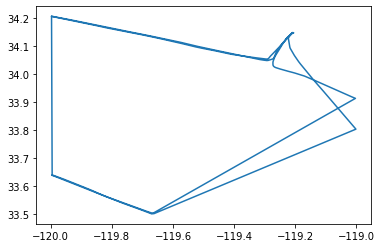

In [12]:
# oneVessel = "../Data/AIS_0117_1217_31_M120_345_M117/MMSI/636015657_Sorted.csv"
# oneVessel = "../Data/AIS_0117_1217_31_M120_345_M117/MMSI/218826000_Sorted.csv"
# oneVessel = "../Data/AIS_0117_1217_31_M120_345_M117/MMSI/220565000_Sorted.csv"
# oneVessel = "../Data/AIS_0117_1217_31_M120_345_M117/MMSI/235011050_Sorted.csv"
oneVessel = "../Data/AIS_SB/MMSI/235011050_Sorted.csv"
# oneVessel = "../Data/AIS_0117_1217_31_M120_345_M117/MMSI/235075024_Sorted.csv"
# oneVessel = "../Data/AIS_0117_1217_31_M120_345_M117/MMSI/238005000_Sorted.csv"
# oneVessel = "../Data/AIS_0117_1217_31_M120_345_M117/MMSI/245417000_Sorted.csv"
# oneVessel = "../Data/AIS_0117_1217_31_M120_345_M117/MMSI/257613000_Sorted.csv"
oneVesselData,_ = aISDM.load_data_from_csv(oneVessel)
print(oneVesselData.shape)
oneVesselLon = oneVesselData['LON']
oneVesselLat = oneVesselData['LAT']
plt.plot(oneVesselLon,oneVesselLat)

In [13]:
oneVesselTime = oneVesselData['DateTime']
for i in range(oneVesselLon.shape[0]):
    print(oneVesselTime[i])

2017-06-28 10:56:47
2017-06-28 10:57:53
2017-06-28 10:58:59
2017-06-28 11:00:04
2017-06-28 11:01:11
2017-06-28 11:02:17
2017-06-28 11:03:23
2017-06-28 11:04:28
2017-06-28 11:05:35
2017-06-28 11:06:40
2017-06-28 11:07:47
2017-06-28 11:08:52
2017-06-28 11:09:53
2017-06-28 11:10:59
2017-06-28 11:12:05
2017-06-28 11:13:11
2017-06-28 11:14:17
2017-06-28 11:15:23
2017-06-28 11:16:28
2017-06-28 11:17:34
2017-06-28 11:18:40
2017-06-28 11:19:47
2017-06-28 11:20:53
2017-06-28 11:21:59
2017-06-28 11:23:04
2017-06-28 11:24:05
2017-06-28 11:25:10
2017-06-28 11:26:16
2017-06-28 11:27:23
2017-06-28 11:28:28
2017-06-28 11:29:29
2017-06-28 11:30:34
2017-06-28 11:31:35
2017-06-28 11:32:41
2017-06-28 11:33:47
2017-06-28 11:34:53
2017-06-28 11:35:59
2017-06-28 11:37:04
2017-06-28 11:38:05
2017-06-28 11:39:10
2017-06-28 11:40:11
2017-06-28 11:41:17
2017-06-28 11:42:23
2017-06-28 11:43:28
2017-06-28 11:44:35
2017-06-28 11:45:40
2017-06-28 11:46:47
2017-06-28 11:47:53
2017-06-28 11:48:58
2017-06-28 11:49:59


(400,)


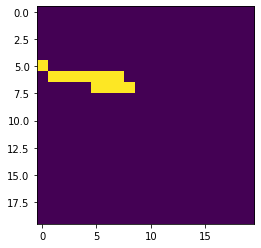

In [14]:
tempGrid = get_grid_object_from_lon_lat(oneVesselLon[0],oneVesselLat[0])
#greedy walk for next 24 hours
greedyTraj = start_greedy_walk(tempGrid,24,xGrid.shape[0],yGrid.shape[0])
print(greedyTraj.shape)
greedyTraj = np.reshape(greedyTraj,(yGrid.shape[0],xGrid.shape[0]))
greedyTraj = np.flip(greedyTraj,axis=0)
plt.imshow(greedyTraj)

In [15]:
np.random.seed(0)
randomWalkSum = []
for i in range(1000):
    tempGrid = get_grid_object_from_lon_lat(oneVesselLon[0],oneVesselLat[0])
    randomWalkTraj = start_random_walk(tempGrid,(24),xGrid.shape[0],yGrid.shape[0])
    randomWalkSum.append(randomWalkTraj.copy())

8
5
5
5
3
5
3
5
8
5
5
5
5
8
2
2
1
7
6
5
7
5
3
5
7
5
5
5
5
3
1
3
3
3
5
3
8
5
5
5
3
1
3
3
3
8
5
5
7
5
5
5
8
5
5
5
5
0
3
3
3
0
3
3
3
7
5
5
5
0
5
3
8
5
5
0
3
3
7
5
5
5
0
3
3
7
5
5
5
8
5
5
5
5
0
3
8
3
5
1
3
7
5
5
5
5
5
3
0
5
3
3
3
3
8
5
5
5
8
5
8
5
5
5
3
5
0
3
3
3
8
5
5
1
3
3
3
8
5
5
5
3
1
3
8
5
5
8
5
8
3
8
2
6
1
7
5
3
2
3
7
3
5
5
5
2
0
1
8
5
5
0
3
1
5
3
3
8
3
7
5
5
5
0
3
3
8
5
5
1
3
3
7
5
5
5
0
3
3
8
5
5
1
3
1
0
5
3
3
8
8
3
3
7
5
5
7
5
5
5
5
8
5
5
1
5
3
3
5
3
3
3
3
0
3
3
7
5
5
5
8
5
5
0
3
3
8
5
5
1
3
3
3
8
5
5
5
5
8
5
1
3
1
7
8
5
5
5
0
3
5
3
3
5
3
3
8
5
5
5
1
5
5
0
3
1
8
3
8
5
5
0
3
3
8
5
5
5
8
5
5
5
0
3
3
3
0
3
3
1
5
1
7
5
5
5
1
3
3
3
7
5
5
5
0
3
3
8
5
5
0
3
3
8
5
5
7
5
5
5
1
3
3
3
8
5
5
1
3
5
3
3
3
8
5
5
1
3
3
5
7
5
5
5
5
3
5
3
5
7
5
5
5
5
0
3
3
8
5
5
8
5
5
5
8
5
5
0
3
3
7
5
5
5
0
5
3
3
1
1
3
8
0
8
5
3
3
2
8
5
2
3
3
3
7
5
5
2
3
3
5
7
5
0
3
3
8
5
5
1
3
3
7
5
5
5
5
0
3
3
3
8
5
5
0
3
3
8
5
5
1
6
5
0
3
3
8
5
5
5
0
3
3
3
7
5
5
5
5
0
3
3
3
8
5
5
5
8
7
5
7
5
5
5
0
3
3
8
5
5
1
3
3
3
8
5
5
1
3
3


5
0
3
3
7
5
5
5
5
0
3
3
3
8
5
5
5
3
1
2
5
1
8
5
5
5
0
3
3
3
8
5
5
5
0
3
3
3
8
5
5
1
3
3
3
8
8
5
5
8
5
5
5
5
1
3
3
3
3
8
5
5
5
1
3
3
0
3
5
7
7
5
3
5
5
5
5
0
3
3
3
7
5
5
5
5
1
3
3
3
3
7
5
5
8
5
5
5
5
3
8
5
5
5
1
3
3
3
3
3
0
3
3
8
5
5
1
3
5
3
7
5
5
5
5
5
3
8
5
5
1
3
3
3
0
3
3
3
8
5
5
5
8
5
5
5
8
5
5
5
8
5
5
7
0
5
5
2
3
3
3
3
3
0
3
5
7
5
5
5
0
3
3
8
5
5
5
8
5
5
5
0
3
3
7
5
5
5
8
6
8
5
5
1
3
3
3
8
5
5
1
3
3
3
7
5
5
5
0
3
3
7
1
8
7
5
5
5
0
3
5
3
3
8
5
5
1
3
3
3
7
5
5
5
0
3
3
7
8
5
5
1
3
3
3
8
5
5
0
3
3
7
5
5
5
5
7
3
5
5
5
5
8
5
5
1
3
3
3
8
5
5
5
8
5
5
0
3
8
5
8
5
5
3
5
5
8
5
5
5
3
1
3
3
3
8
5
5
0
3
3
5
3
8
5
5
0
3
3
8
8
5
5
1
3
3
3
8
5
5
5
3
5
0
3
3
3
7
2
3
8
5
5
5
7
5
1
3
7
5
5
2
3
3
3
8
5
5
5
8
5
5
5
5
3
0
3
3
7
5
5
5
8
5
5
5
5
8
5
5
1
3
3
3
0
3
3
3
3
0
1
5
7
5
5
5
1
3
3
3
7
5
5
5
1
3
3
3
7
5
5
5
0
3
3
8
8
5
5
1
3
3
3
7
5
5
5
5
7
5
5
5
1
3
3
3
7
5
5
5
7
5
5
5
8
5
5
5
1
8
5
3
8
5
7
6
2
6
5
1
7
1
3
5
8
5
8
1
5
8
5
5
5
1
3
3
3
7
5
5
5
8
5
3
3
8
0
6
7
5
5
5
0
3
3
7
5
5
5
0
3
3
7
5
5
5
0
3
3
8


3
5
3
3
8
5
5
1
3
3
3
8
5
5
8
5
5
5
5
8
5
5
0
3
3
8
5
5
0
3
3
8
5
5
1
3
3
3
8
5
5
5
8
8
5
5
0
3
3
7
5
5
5
1
3
3
8
5
1
3
3
3
8
5
5
5
8
7
5
5
5
1
3
3
3
8
5
5
3
5
1
3
3
3
8
5
5
5
3
8
5
8
5
5
5
6
6
3
5
2
6
2
5
5
5
5
5
8
5
5
7
1
5
5
8
8
5
5
0
3
3
7
5
5
5
5
7
5
5
5
5
0
5
3
3
3
3
0
3
7
5
5
5
0
1
0
7
7
3
5
3
7
5
5
5
5
1
1
1
7
0
3
1
7
5
5
5
1
3
3
7
5
5
5
3
0
0
1
7
5
0
7
0
8
3
8
3
8
5
5
1
3
3
3
7
5
5
2
3
3
3
8
5
5
0
3
3
7
5
5
5
8
5
5
5
5
8
5
5
8
5
7
6
1
7
6
3
5
3
5
2
1
6
3
3
7
5
5
5
1
3
1
3
3
2
3
5
7
5
3
0
1
2
7
3
2
5
5
6
1
5
7
3
7
5
5
5
8
3
5
5
5
5
5
0
3
3
0
3
3
3
8
5
7
5
5
5
0
3
3
8
5
5
0
6
5
5
0
3
3
8
5
5
1
3
5
3
8
5
5
1
3
3
3
8
5
5
5
8
5
5
5
0
3
3
7
5
5
5
8
7
8
5
7
6
2
5
6
5
2
5
3
5
5
5
1
3
3
3
8
5
5
5
5
3
8
5
5
8
5
5
5
5
8
5
5
5
1
3
3
3
0
5
3
0
3
5
3
7
8
5
5
5
0
3
3
3
8
5
5
1
3
3
3
8
5
5
8
5
5
5
0
3
7
5
5
5
0
3
3
8
5
5
1
3
3
5
3
3
8
5
5
0
3
3
8
5
8
5
5
0
3
3
7
5
5
5
0
3
3
8
5
5
1
3
3
3
8
5
5
5
7
5
5
5
5
3
0
3
2
5
3
5
3
0
1
6
8
5
3
3
8
3
5
3
8
5
5
0
3
3
8
5
5
0
3
3
8
5
5
1
3
3
3
7
5
5
5
0
7


5
5
5
0
3
3
3
7
8
5
5
5
3
5
0
3
3
3
7
5
8
5
5
3
5
5
5
1
3
3
0
3
8
5
5
0
3
3
7
5
5
5
5
0
3
3
3
8
5
5
1
3
3
7
5
5
8
5
5
5
0
3
3
2
1
3
3
1
2
3
5
3
5
6
2
3
5
8
5
3
8
5
5
0
3
3
7
1
8
5
5
5
8
5
5
5
1
3
3
3
3
8
5
5
7
2
3
8
5
5
5
3
0
3
3
8
5
5
1
3
3
3
8
5
5
5
7
5
5
3
7
5
5
5
0
3
3
7
5
5
5
5
8
5
5
5
1
3
3
3
3
3
7
5
5
5
5
8
5
5
5
0
3
3
3
3
5
8
5
5
5
0
3
3
5
3
8
5
5
1
1
3
3
5
3
3
5
5
3
5
3
3
5
1
0
1
7
2
3
8
7
5
5
5
0
3
3
7
5
5
5
0
3
3
7
5
5
5
1
3
3
3
8
5
8
5
5
5
3
5
8
1
3
8
5
5
5
0
3
3
8
7
7
5
5
2
5
5
7
5
5
5
1
3
3
3
7
5
5
5
0
3
3
8
5
5
8
6
1
6
3
6
8
5
5
5
3
0
3
3
7
5
5
5
0
3
3
7
5
5
5
0
3
3
5
3
8
5
5
1
3
3
3
8
5
5
1
3
3
3
7
5
5
5
1
3
3
3
8
5
7
5
3
5
5
5
0
3
3
8
5
5
0
3
3
7
5
5
5
5
3
5
8
5
8
5
5
5
0
3
3
3
8
5
5
0
3
3
8
5
5
5
8
5
5
5
1
3
8
5
5
0
3
3
8
5
5
5
1
5
3
7
8
0
3
1
3
3
3
7
5
5
8
5
5
1
3
3
3
8
5
5
1
3
3
3
8
5
5
0
3
3
8
5
5
5
8
5
5
1
3
3
3
8
5
5
0
3
3
8
5
5
0
3
3
7
5
5
5
5
7
5
5
5
5
1
3
3
3
3
8
5
5
1
3
3
3
7
5
5
5
0
3
3
7
5
5
5
0
3
3
8
5
5
1
3
3
3
8
5
5
0
1
5
8
5
3
1
8
5
5
5
0
3
3
7
5
5
1
3


0
3
3
3
7
5
5
5
1
3
3
3
5
3
8
2
3
3
8
5
8
5
5
5
0
3
3
3
8
5
5
8
5
5
5
5
8
5
3
5
6
3
1
6
7
5
5
5
8
5
5
5
5
5
0
3
3
1
0
0
2
5
3
3
5
8
1
1
8
5
5
5
7
5
5
5
5
3
5
5
8
3
2
3
7
5
5
5
8
5
5
8
8
5
5
1
3
3
3
8
5
5
5
3
1
3
3
3
7
5
5
5
5
0
3
3
8
5
5
0
3
3
8
5
5
5
3
1
1
8
3
3
3
7
5
5
0
3
1
0
5
3
8
5
5
0
3
3
5
3
7
5
5
5
5
3
5
0
3
0
3
5
0
2
8
5
5
1
3
3
3
7
5
5
5
1
3
3
3
8
5
5
5
8
5
5
5
7
8
5
5
0
3
3
8
5
5
5
8
5
5
5
1
3
3
1
1
3
5
5
5
0
8
5
5
0
3
3
8
5
5
5
0
3
3
3
8
5
5
5
3
0
3
3
8
5
7
5
5
5
0
3
3
8
5
5
8
5
5
5
5
8
5
5
5
5
5
1
5
1
8
5
5
5
3
5
1
5
5
5
2
3
1
5
5
1
7
1
7
1
7
1
5
8
8
5
5
5
0
3
3
3
8
5
5
5
8
5
5
3
5
5
0
3
3
3
0
3
8
5
5
5
0
3
3
3
8
5
5
5
3
5
7
6
5
3
5
8
5
5
3
3
8
5
5
5
8
5
5
5
5
7
6
0
5
3
7
3
3
0
3
3
5
5
5
3
8
5
5
1
3
3
3
8
5
5
1
7
5
1
2
0
2
2
6
5
3
2
7
1
8
5
5
3
5
5
0
3
3
3
7
5
5
5
1
3
3
8
5
8
5
5
5
5
8
5
5
5
3
5
0
2
5
1
1
5
1
7
8
5
5
1
7
7
1
7
5
8
7
5
5
5
0
5
3
3
3
8
5
5
0
3
3
8
5
5
0
3
3
8
5
5
8
5
5
5
8
5
5
5
8
5
5
5
1
7
0
1
6
3
7
3
6
2
3
7
7
5
5
5
0
3
3
8
5
5
0
3
3
7
5
5
5
5
0
3
3
3
7
5


7
5
5
5
0
3
3
8
5
1
3
3
8
5
5
0
3
3
8
5
5
5
0
3
7
5
5
5
0
3
3
8
5
5
5
3
0
3
3
7
5
5
5
1
3
3
3
8
8
5
5
5
0
3
3
3
7
5
5
5
5
8
5
5
5
5
0
3
3
3
7
5
7
5
5
5
8
5
5
5
5
0
6
5
8
7
3
2
6
3
5
1
7
2
7
1
8
5
5
0
3
3
7
5
5
5
5
8
5
5
5
5
3
8
5
1
3
3
8
5
8
5
5
5
5
3
0
3
3
3
8
5
5
1
3
3
3
7
5
5
5
5
8
5
7
5
5
5
5
8
5
5
5
0
3
3
7
5
5
5
8
5
5
5
0
3
3
3
7
5
5
5
5
8
5
5
5
3
0
3
8
5
1
3
3
7
5
5
5
0
3
3
8
5
5
8
5
5
5
5
5
7
5
5
1
5
3
6
5
5
0
3
3
7
5
5
7
5
5
1
3
3
8
5
5
0
3
3
7
5
5
5
1
3
3
3
7
5
5
5
7
5
5
5
0
3
3
7
5
5
5
5
0
3
3
3
7
5
5
5
0
3
3
8
8
6
7
7
5
1
1
2
5
0
3
3
1
5
5
5
3
5
5
5
5
3
1
1
7
5
5
5
1
3
3
3
7
5
3
5
5
5
0
3
3
7
5
5
5
5
3
0
7
5
5
5
5
3
8
5
5
5
1
3
3
3
0
3
3
3
7
5
5
5
8
5
8
5
5
1
3
3
3
7
5
5
5
5
8
5
5
5
5
1
5
2
7
5
2
5
8
5
5
0
3
0
5
3
5
5
1
3
3
8
0
2
5
5
5
7
5
3
1
5
8
5
5
0
3
3
8
5
5
8
5
5
5
5
0
5
3
3
7
5
5
0
3
3
7
5
5
5
5
8
5
5
5
5
7
5
5
5
5
3
1
3
3
3
7
5
5
5
5
3
7
5
5
5
5
8
5
5
5
8
3
8
1
5
2
2
3
5
3
5
3
5
8
5
5
1
3
3
3
7
5
5
5
5
8
5
3
5
3
5
5
5
0
5
5
5
7
5
5
1
3
3
7
5
5
5
5
3
5
8
5
5
5
0
3
3


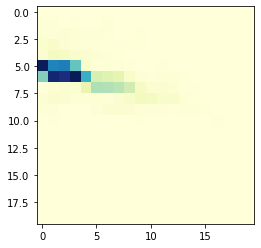

In [16]:
randomWalkHM = randomWalkSum[0].copy()

for i in range(1, len(randomWalkSum)):
    randomWalkHM = randomWalkHM + randomWalkSum[i]
    
randomWalkHM = np.reshape(randomWalkHM,(yGrid.shape[0],xGrid.shape[0]))
randomWalkHM = np.flip(randomWalkHM,axis=0)
plt.imshow(randomWalkHM,cmap=plt.get_cmap('YlGnBu'))

In [17]:
# timeIntervalList = "../Data/AIS_0117_1217_31_M120_345_M117/Output/TimeInterval6.txt"
# timeIntervalList = "../Data/AIS_0117_1217_31_M120_345_M117/Output/TimeInterval9.txt"
# timeIntervalList = "../Data/AIS_0117_1217_31_M120_345_M117/Output/TimeInterval3.txt"
# timeIntervalList = "../Data/AIS_0117_1217_31_M120_345_M117/Output/TimeInterval5.txt"
timeIntervalList = "../Data/AIS_SB/TenMinIntvl1706To1707.txt"
# timeIntervalList = "../Data/AIS_0117_1217_31_M120_345_M117/Output/TimeInterval8.txt"
# timeIntervalList = "../Data/AIS_0117_1217_31_M120_345_M117/Output/TimeInterval11.txt"
# timeIntervalList = "../Data/AIS_0117_1217_31_M120_345_M117/Output/TimeInterval3.txt"
# timeIntervalList = "../Data/AIS_0117_1217_31_M120_345_M117/Output/TimeInterval3.txt"
timeWindows = [line.rstrip('\n') for line in open(timeIntervalList)]
oneVesselLonOnce = []
oneVesselLatOnce = []

hourCounter = 0
oneVesselData48 = pd.DataFrame()
#based on time stamps 
for timeSlot in timeWindows:
    temp = timeSlot.split(',')
    startTime = temp[0]
    endTime = temp[1]

    hourlyDF = aISDM.filter_based_on_time_stamp(oneVesselData,'DateTime',startTime,endTime)
#     print(hourlyDF.shape)
    oneVesselRows = hourlyDF.shape[0]
    if(oneVesselRows > 0):
        if(hourCounter < 24):
            oneVesselData48 = oneVesselData48.append(hourlyDF, ignore_index = True)
            hourCounter = hourCounter + 1
        oneVesselLonOnce.append(hourlyDF.iloc[0,3])
        oneVesselLatOnce.append(hourlyDF.iloc[0,2])
        

In [18]:
def compute_heat_map(dF):
    npHeatMap = np.ones((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    for i in range(len(boundaryArray)):
        boundedDF = aISDM.filter_based_on_lon_lat(dF,boundaryArray[i][0]\
            ,boundaryArray[i][1]\
            ,boundaryArray[i][2]\
            ,boundaryArray[i][3]\
            )
        
        if(boundedDF.shape[0] > 0):
            npHeatMap[i] = 0
    
    return npHeatMap

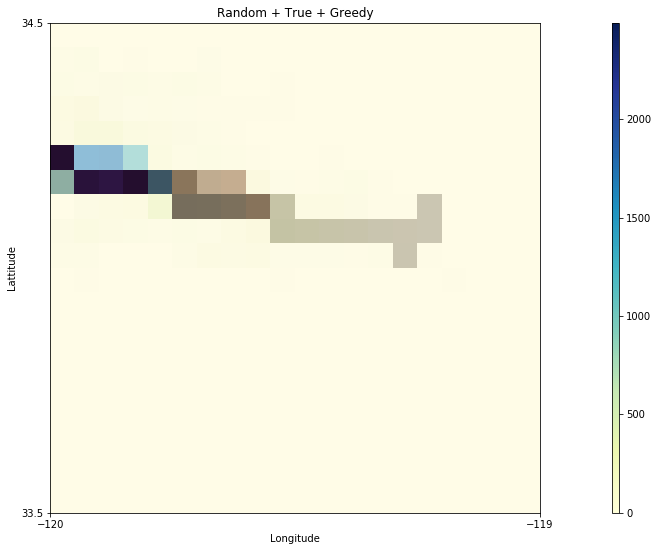

In [19]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8.5

if useAspect == 1:
    figHeight = figWidth/aspectRatio


vesselTrueTraj = compute_heat_map(oneVesselData48)
vesselTrueTraj = np.reshape(vesselTrueTraj,(yGrid.shape[0],xGrid.shape[0]))
vesselTrueTraj = np.flip(vesselTrueTraj,axis=0)
    
    
fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.1, 0.80, 0.80])
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Lattitude')
ax1.set_title('Random + True + Greedy')
ax1.set_xticks([lonMin,lonMax])
ax1.set_yticks([latMin,latMax])

iMShowHandler = ax1.imshow(randomWalkHM,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax])
ax1.imshow(vesselTrueTraj,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax],alpha = 0.3)
ax1.imshow(greedyTraj,cmap=plt.get_cmap('Reds'),extent=[lonMin,lonMax,latMin,latMax],alpha = 0.3)

ax2 = fig.add_axes([0.94, 0.1, 0.01, 0.80])
fig.colorbar(iMShowHandler,ax2)
fig.savefig("RandomWalkPlusTruePlusGreedy.png")

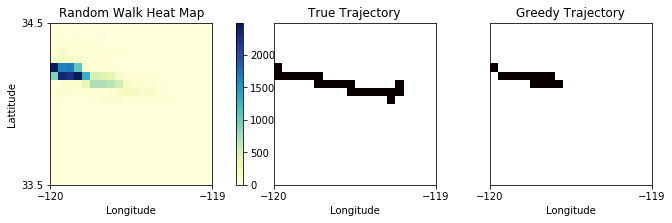

In [20]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 3

if useAspect == 1:
    figHeight = figWidth/aspectRatio

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.29, 0.75])
ax2 = fig.add_axes([0.41, 0.15, 0.29, 0.75])
ax3 = fig.add_axes([0.71, 0.15, 0.29, 0.75])
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Lattitude')
ax2.set_xlabel('Longitude')
ax3.set_xlabel('Longitude')



ax1.set_title('Random Walk Heat Map')
ax2.set_title('True Trajectory')
ax3.set_title('Greedy Trajectory')
ax1.set_xticks([lonMin,lonMax])
ax2.set_xticks([lonMin,lonMax])
ax3.set_xticks([lonMin,lonMax])
ax1.set_yticks([latMin,latMax])
ax2.set_yticks([])
ax3.set_yticks([])

greedyTrajI = np.invert(greedyTraj > 0)
iMShowHandler = ax1.imshow(randomWalkHM,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax])
ax2.imshow(vesselTrueTraj,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
ax3.imshow(greedyTrajI,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])

ax4 = fig.add_axes([0.39, 0.15, 0.01, 0.75])

fig.colorbar(iMShowHandler,ax4)
fig.savefig("RandomWalkSubPlot.png")